In [59]:
# Libraries
import time
import glob
import os
import os.path
import fnmatch
from pathlib import Path
import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import matplotlib.pyplot as plt
import cv2                                              # Library for image processing
import datetime as dt
from PIL import Image
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.utils import shuffle

# TensorFlow / Keras
import tensorflow as tf                                 # Deep Learning Tool
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, layers, models, losses, Model, optimizers
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D, MaxPool2D,BatchNormalization, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.core.display import display, HTML
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [23]:
def salt(img, n):
    for k in range(n):
        i = int(np.random.random() * img.shape[1])
        j = int(np.random.random() * img.shape[0])
        if img.ndim == 2:
            img[j,i] = 255
        elif img.ndim == 3:
            img[j,i,0]= 255
            img[j,i,1]= 255
            img[j,i,2]= 255
        return img


# BG Remover  inspired by : @Messaoud Makhlouf 
def bg_remov(image):
    result = salt(image, 10)
    median = cv2.medianBlur(result,5)
    gray = cv2.cvtColor(median, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(gray, 85, 255, cv2.THRESH_BINARY)
    
    return blackAndWhiteImage


In [24]:
%%time
filepaths = []
filenames = []
root_folder = '../input/ecgleads/MI/'
folders = [os.path.join(root_folder, x) for x in ('I', 'I_Neg','II', 'II_Neg','III', 'III_Neg','aVR', 'aVR_Neg','aVL', 'aVL_Neg','aVF', 'aVF_Neg','V1','V2','V3','V4','V5','V6' )]
for folder in folders:
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            fp =os.path.join(folder, filename)
            filepaths.append(fp)
            filenames.append(filename)

MI = pd.DataFrame(filenames, columns=['filename'])
MI['filepaths'] = filepaths
MI['label'] = 'MI'

CPU times: user 20 ms, sys: 17.4 ms, total: 37.3 ms
Wall time: 1.02 s


In [25]:
%%time
filepaths = []
filenames = []
root_folder = '../input/ecgleads/Normal/'
folders = [os.path.join(root_folder, x) for x in ('I', 'I_Neg','II', 'II_Neg','III', 'III_Neg','aVR', 'aVR_Neg','aVL', 'aVL_Neg','aVF', 'aVF_Neg','V1','V2','V3','V4','V5','V6' )]
for folder in folders:
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            fp =os.path.join(folder, filename)
            filepaths.append(fp)
            filenames.append(filename)

Normal = pd.DataFrame(filenames, columns=['filename'])
Normal['filepaths'] = filepaths
Normal['label'] = 'Normal'

CPU times: user 15.8 ms, sys: 20 ms, total: 35.8 ms
Wall time: 877 ms


In [29]:
df = pd.concat([MI,Normal],ignore_index=True)
df.head()


,filename,filepaths,label
0,MI_54.png,../input/ecgleads/MI/I/MI_54.png,MI
1,MI_133.png,../input/ecgleads/MI/I/MI_133.png,MI
2,MI_66.png,../input/ecgleads/MI/I/MI_66.png,MI
3,MI_36.png,../input/ecgleads/MI/I/MI_36.png,MI
4,MI_111.png,../input/ecgleads/MI/I/MI_111.png,MI


In [35]:
#df.drop(df.tail(2).index,inplace = True)

In [38]:
%%time
# Labelencoder to encode the labels 
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

data = []     # initialize an empty numpy array
image_size = 100      # image size taken is 100 here. one can take other size too
# the size of the images is between 52 and 75 so choose what ever size you want.
for i in range(len(df)):
    # here I read the image 
    img_array = cv2.imread(df['filepaths'][i])   # converting the image to gray scale
    img_array = bg_remov(img_array)
    new_img_array = cv2.resize(img_array, (image_size, image_size)) 
    data.append([new_img_array, df['label'][i]])

CPU times: user 53.9 s, sys: 18.6 s, total: 1min 12s
Wall time: 56.6 s


In [39]:
np.random.shuffle(data)

x = []
y = []
for image in data:
    x.append(image[0])
    y.append(image[1])

In [40]:
# converting x & y to numpy array as they are list
x = np.array(x)
y = np.array(y)

In [41]:
x = x.reshape(-1, 100, 100, 1)

In [42]:
# split the data
X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.3, random_state = 0)

In [43]:
X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255

In [44]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((5037, 100, 100, 1), (5037,), (2159, 100, 100, 1), (2159,))

In [47]:
y_train

array([1, 1, 0, ..., 1, 1, 1])

In [50]:
# Function to plot History of NN  Learning.
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [54]:
cnn = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 1)),
tf.keras.layers.MaxPooling2D((2, 2)),

tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
tf.keras.layers.MaxPooling2D((2, 2)),

# tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [55]:
cnn.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2166848   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [56]:
# you can use hostory to check on the progress of your model with tensorboard...
history = cnn.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
40/40 [==============================] - 37s 903ms/step - loss: 0.8798 - accuracy: 0.5061 - val_loss: 0.6929 - val_accuracy: 0.5039
Epoch 2/20
40/40 [==============================] - 36s 894ms/step - loss: 0.6933 - accuracy: 0.4847 - val_loss: 0.6934 - val_accuracy: 0.4961
Epoch 3/20
40/40 [==============================] - 36s 892ms/step - loss: 0.6910 - accuracy: 0.5133 - val_loss: 0.6972 - val_accuracy: 0.4961
Epoch 4/20
40/40 [==============================] - 36s 895ms/step - loss: 0.6732 - accuracy: 0.5706 - val_loss: 0.6196 - val_accuracy: 0.6596
Epoch 5/20
40/40 [==============================] - 36s 895ms/step - loss: 0.5868 - accuracy: 0.7011 - val_loss: 0.5236 - val_accuracy: 0.7392
Epoch 6/20
40/40 [==============================] - 36s 899ms/step - loss: 0.4838 - accuracy: 0.7675 - val_loss: 0.4481 - val_accuracy: 0.7818
Epoch 7/20
40/40 [==============================] - 36s 892ms/step - loss: 0.3761 - accuracy: 0.8363 - val_loss: 0.4003 - val_accuracy: 0.7957

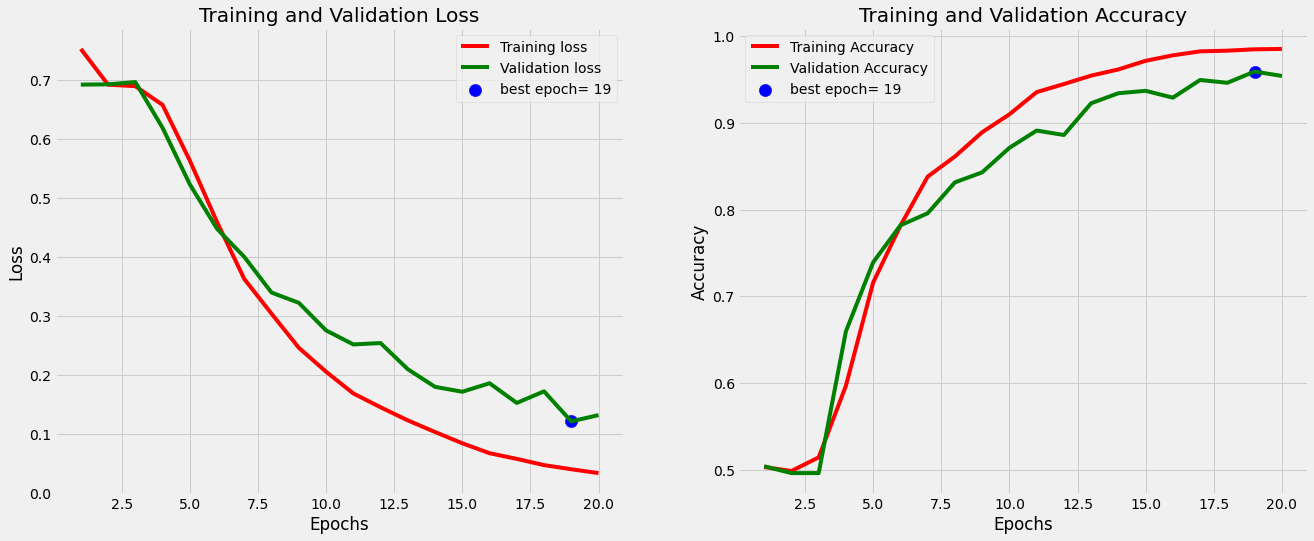

In [57]:
tr_plot(history,0)

In [58]:
score_head_model= cnn.evaluate(X_val,y_val)
print("Test Loss:", score_head_model[0])
print("Test Accuracy:", score_head_model[1])

68/68 [==============================] - 4s 52ms/step - loss: 0.1317 - accuracy: 0.9541
Test Loss: 0.13170377910137177
Test Accuracy: 0.9541454315185547
